# **SUPERCONDUCTIVITY**

Here, from each of the VdP_B(x)T.dat file we extrapolate the Rs, then we find the Tc for every curve and plot the B vs T function to identify the sc phase diagram.

x = 0, 0.4, 0.8, 1.6, 2.4, 3.2, 3.6, 3.8, 4.0



Functions and libs

In [30]:

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:

def calculate_sheet_resistance_vdp(R_A, R_B, delta=0.0005, max_iterations=10000) -> float:
    # Initial z_i, or z_0
    z_prev = (2 * np.log(2)) / (np.pi * (R_A + R_B))

    iterations = 0
    while iterations < max_iterations:
        # y_i
        # Using 1/exp(x) which is equivalent to exp(-x) for numerical stability
        y_i = np.exp(-np.pi * z_prev * R_A) + np.exp(-np.pi * z_prev * R_B)

        # z_i
        numerator = (1 - y_i) / np.pi
        denominator = (R_A * np.exp(-np.pi * z_prev * R_A) + R_B * np.exp(-np.pi * z_prev * R_B))

        if abs(denominator) < 1e-18: # A small threshold to prevent division by zero
            print(f"Warning: Denominator in z_i calculation is too small. R_A={R_A}, R_B={R_B}. Stopping.")
            return np.nan
        
        z_curr = z_prev - (numerator / denominator)

        # Check for convergence
        if z_curr == 0: # Avoid division by zero if z_curr becomes 0
            if z_prev == 0: # If both are zero, it's converged to zero
                break
            else: # If z_curr is zero but z_prev isn't, the relative change is infinite
                # This indicates a potential issue or Rs becoming infinitely large, meaning bad R_A, R_B
                print(f"Warning: z_curr became 0. R_A={R_A}, R_B={R_B}. Stopping.")
                return np.nan

        relative_change = abs((z_curr - z_prev) / z_curr)

        if relative_change < delta:
            R_s = 1 / z_curr
            return R_s

        z_prev = z_curr
        iterations += 1

    print(f"Warning: Calculation did not converge within {max_iterations} iterations for R_A={R_A}, R_B={R_B}.")
    return np.nan

Read the data

In [38]:


# --- Parameters ---
data_dir = "C:/Users/fzana/OneDrive/Desktop/quantum engineering/Advanced experimental physics/Nb-Characterization/SUPERCONDUCTIVITY/DataSets"  # Change to your directory if needed
file_pattern = os.path.join(data_dir, "2025-04-08_VdP_B*T.dat")
intra_cutoff = 0       # 30 mK
inter_cutoff = 0       # 10 uK

# --- Column indices (0-based) ---
columns_to_read = [5, 6, 7, 16, 17, 18]  # front_temp, front_temp_fluct, front_R, back_temp, back_temp_fluct, back_R

# --- Store results ---
raw_data = {}
filtered_data = {}

# --- Loop over all files ---
for filepath in sorted(glob.glob(file_pattern)):
    # Extract the x value from the filename
    basename = os.path.basename(filepath)
    try:
        x_str = basename.split("B")[-1].split("T.dat")[0]
        x_key = x_str.replace('.', '_')  # For variable safety
        x_val = float(x_str)
    except Exception as e:
        print(f"Skipping file {basename} due to parsing error: {e}")
        continue

    # Load the required columns only
    try:
        data = pd.read_csv(filepath, delim_whitespace=True, header=None, usecols=columns_to_read)
        data.columns = ['front_temp', 'front_temp_fluct', 'front_R', 'back_temp', 'back_temp_fluct', 'back_R']
    except Exception as e:
        print(f"Error reading {basename}: {e}")
        continue

    # Store raw values
    for col in data.columns:
        raw_data[f"{col}_raw_{x_str}"] = data[col].copy()

    # Compute average temperature
    avg_temp = (data['front_temp'] + data['back_temp']) / 2

    # Mask
    sel_mask = (
        (data['front_R'] > 0) & (data['back_R'] > 0) &
        (data['front_temp_fluct'] <= intra_cutoff) &
        (data['back_temp_fluct'] <= intra_cutoff) &
        (abs(data['front_temp'] - data['back_temp']) == inter_cutoff)
    )

    # Apply mask and store filtered values
    filtered_data[f"Rf_{x_str}"] = data['front_R'][sel_mask].values
    filtered_data[f"Rb_{x_str}"] = data['back_R'][sel_mask].values
    filtered_data[f"Tavg_{x_str}"] = avg_temp[sel_mask].values
    filtered_data[f"Tf_{x_str}"] = data['front_temp'][sel_mask].values
    filtered_data[f"Tb_{x_str}"] = data['back_temp'][sel_mask].values

# Now you can access e.g. raw_data['back_temp_raw_3_6'] or filtered_data['Tb_3_6']
# Optionally save the results
# Example: save filtered Tb to CSV
# for key, val in filtered_data.items():
#     np.savetxt(f"{key}.csv", val, delimiter=",")

print("Processing complete. Variables are stored in raw_data and filtered_data dictionaries.")


Skipping file 2025-04-08_VdP_B_0T.dat due to parsing error: could not convert string to float: '_0'
Skipping file 2025-04-08_VdP_B_from_0.4_to_0T.dat due to parsing error: could not convert string to float: '_from_0.4_to_0'
Processing complete. Variables are stored in raw_data and filtered_data dictionaries.


C:\Users\fzana\AppData\Local\Temp\ipykernel_24232\2553082405.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, delim_whitespace=True, header=None, usecols=columns_to_read)
C:\Users\fzana\AppData\Local\Temp\ipykernel_24232\2553082405.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, delim_whitespace=True, header=None, usecols=columns_to_read)
C:\Users\fzana\AppData\Local\Temp\ipykernel_24232\2553082405.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, delim_whitespace=True, header=None, usecols=columns_to_read)
C:\Users\fzana\AppData\Local\Temp\ipykernel_24232\2553082405.py:28: FutureWarning: The 'delim_

In [39]:
# --- Compute and store sheet resistance Rs for each x ---
for key in list(filtered_data.keys()):
    if key.startswith("Rf_"):
        x_str = key.split("_")[1]

        Rf_vals = filtered_data[f"Rf_{x_str}"]
        Rb_vals = filtered_data[f"Rb_{x_str}"]

        if len(Rf_vals) != len(Rb_vals):
            print(f"Length mismatch for x = {x_str}. Skipping Rs computation.")
            continue

        # Calculate sheet resistance for each pair
        Rs_vals = np.array([
            calculate_sheet_resistance_vdp(R_A, R_B)
            for R_A, R_B in zip(Rf_vals, Rb_vals)
        ])

        filtered_data[f"Rs_{x_str}"] = Rs_vals


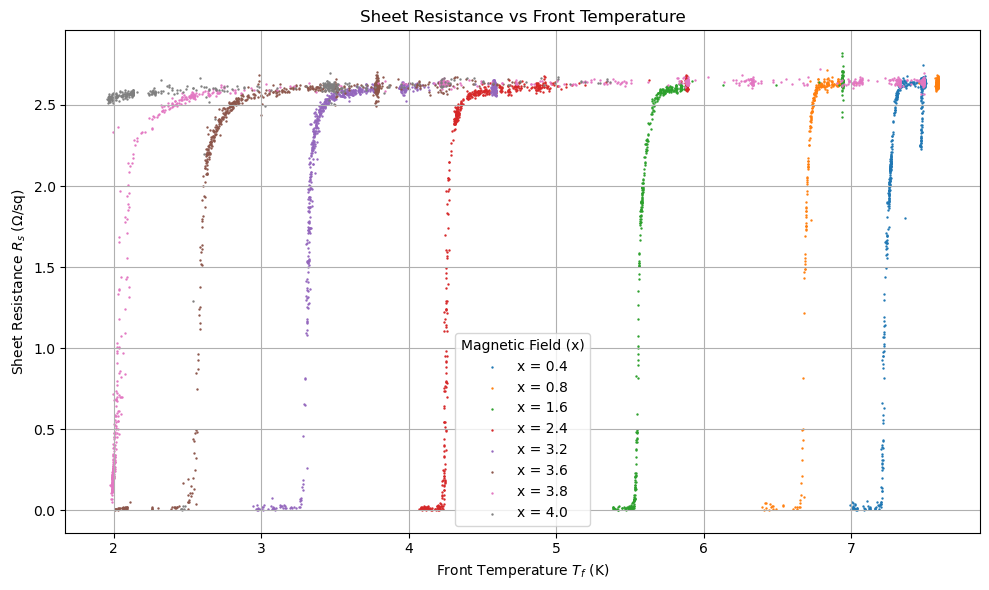

In [40]:
# --- Plot all Rs_x vs Tf_x as scatter plots in one figure ---
plt.figure(figsize=(10, 6))

for key in sorted(filtered_data.keys()):
    if key.startswith("Rs_"):
        x_str = key.split("_")[1]
        Rs_vals = filtered_data[key]
        Tf_key = f"Tf_{x_str}"

        # Check if Tf_x exists
        if Tf_key not in filtered_data:
            print(f"Missing {Tf_key} for plotting Rs_{x_str}, skipping.")
            continue

        Tf_vals = filtered_data[Tf_key]

        if len(Rs_vals) != len(Tf_vals):
            print(f"Length mismatch for Rs_{x_str} and Tf_{x_str}, skipping.")
            continue

        # # Sort values for cleaner plotting
        # sorted_indices = np.argsort(Tf_vals)
        # Tf_sorted = Tf_vals[sorted_indices]
        # Rs_sorted = Rs_vals[sorted_indices]

        # Scatter plot
        plt.scatter(Tf_vals, Rs_vals, label=f"x = {x_str}", s=.5)

# Plot formatting
plt.xlabel("Front Temperature $T_f$ (K)")
plt.ylabel("Sheet Resistance $R_s$ (Ω/sq)")
plt.title("Sheet Resistance vs Front Temperature")
plt.legend(title="Magnetic Field (x)")
plt.grid(True)
plt.tight_layout()
plt.show()

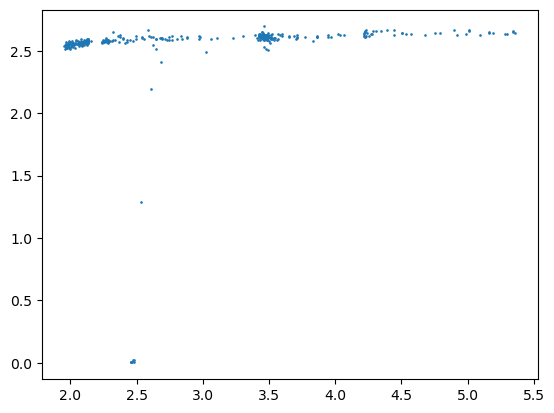

In [41]:
plt.scatter(filtered_data['Tf_4.0'], filtered_data['Rs_4.0'], s=.8)

In [46]:
print(filtered_data.keys())

dict_keys(['Rf_0.4', 'Rb_0.4', 'Tavg_0.4', 'Tf_0.4', 'Tb_0.4', 'Rf_0.8', 'Rb_0.8', 'Tavg_0.8', 'Tf_0.8', 'Tb_0.8', 'Rf_1.6', 'Rb_1.6', 'Tavg_1.6', 'Tf_1.6', 'Tb_1.6', 'Rf_2.4', 'Rb_2.4', 'Tavg_2.4', 'Tf_2.4', 'Tb_2.4', 'Rf_3.2', 'Rb_3.2', 'Tavg_3.2', 'Tf_3.2', 'Tb_3.2', 'Rf_3.6', 'Rb_3.6', 'Tavg_3.6', 'Tf_3.6', 'Tb_3.6', 'Rf_3.8', 'Rb_3.8', 'Tavg_3.8', 'Tf_3.8', 'Tb_3.8', 'Rf_4.0', 'Rb_4.0', 'Tavg_4.0', 'Tf_4.0', 'Tb_4.0', 'Rs_0.4', 'Rs_0.8', 'Rs_1.6', 'Rs_2.4', 'Rs_3.2', 'Rs_3.6', 'Rs_3.8', 'Rs_4.0'])


## **$T_C$ Evaluation**

### **Univariate spline**

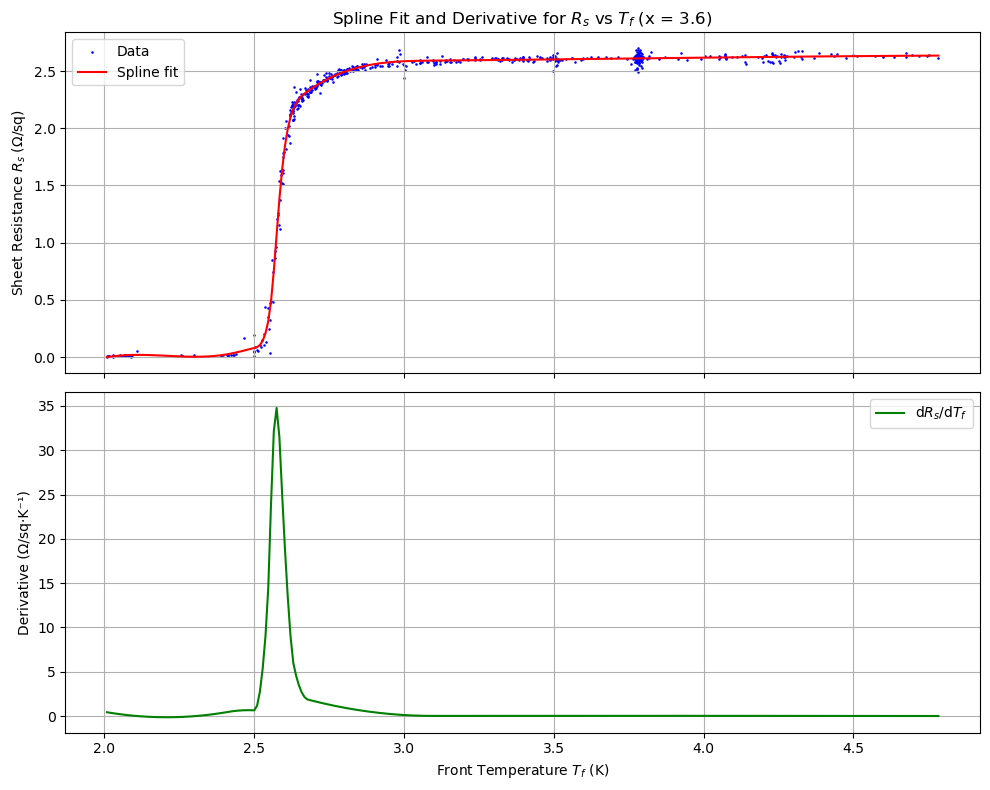

In [ ]:
from scipy.interpolate import UnivariateSpline

# Extract and sort Tf and Rs
Tf = filtered_data['Tf_3.6']
Rs = filtered_data['Rs_3.6']

sorted_indices = np.argsort(Tf)
Tf_sorted = Tf[sorted_indices]
Rs_sorted = Rs[sorted_indices]

# Fit the smoothing spline
spline = UnivariateSpline(Tf_sorted, Rs_sorted, s=1.5, k=3)

# Evaluate the spline on a fine grid
Tf_fine = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 300)
Rs_fine = spline(Tf_fine)

# --- Compute first derivative ---
spline_derivative = spline.derivative(n=1)
Rs_derivative = spline_derivative(Tf_fine)

# --- Plot ---
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot original data and spline
ax[0].scatter(Tf, Rs, s=.7, color='blue', label="Data")
ax[0].plot(Tf_fine, Rs_fine, color='red', label="Spline fit")
ax[0].set_ylabel("Sheet Resistance $R_s$ (Ω/sq)")
ax[0].set_title("Spline Fit and Derivative for $R_s$ vs $T_f$ (B = 3.6T)")
ax[0].legend()
ax[0].grid(True)

# Plot derivative
ax[1].plot(Tf_fine, Rs_derivative, color='green', label="d$R_s$/d$T_f$")
ax[1].set_xlabel("Front Temperature $T_f$ (K)")
ax[1].set_ylabel("Derivative (Ω/sq·K⁻¹)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

## **Fermi-Dirac like function**

In [93]:
from scipy.optimize import curve_fit

Rho_0 = 2.6427

# Fermi-Dirac like function for superconducting transition
def FD_model(T, T_c, delta_T):
    return Rho_0 / (1 + np.exp(-(T - T_c) / delta_T))

def dR_dT_FD(T, T_c, delta_T):
    exp_term = np.exp(-(T - T_c) / delta_T)
    return (Rho_0 / delta_T) * (exp_term / (1 + exp_term)**2)

# Get filtered Tf and Rs data 
Tf = filtered_data['Tf_3.6']
Rs = filtered_data['Rs_3.6']

# Sort
sorted_idx = np.argsort(Tf)
Tf_sorted = Tf[sorted_idx]
Rs_sorted = Rs[sorted_idx]

# Fit
popt, _ = curve_fit(FD_model, Tf_sorted, Rs_sorted, p0=[Tf_sorted[np.argmax(np.gradient(-Rs))], 0.1])
T_c_fit, delta_T_fit = popt

# Evaluate model
Tf_fit = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 500)
Rs_fit = FD_model(Tf_fit, *popt)

#DERIVATIVE
dRs_numeric = np.gradient(Rs_fit, Tf_fit) #numerical gradient to camper with the fit
# Remove NaNs or infs from both arrays
valid_mask = np.isfinite(dRs_numeric) & np.isfinite(Tf_fit)
Tf_valid = Tf_fit[valid_mask]
dRs_numeric_valid = dRs_numeric[valid_mask]


popt_dR, _ = curve_fit(dR_dT_FD, Tf_valid, dRs_numeric_valid, p0=popt)
dRs_fit = dR_dT_FD(Tf_valid, *popt_dR )

print('Tc (from derivative fit):', popt_dR[0])



Tc (from derivative fit): 2.5881853994148507


In [94]:
# find FWHM = Tc(90%) + Tc(10%) 
T_fwhm=[]
for i in range(len(Rs_fit)): 
    if(dRs_fit[i]>np.max(dRs_fit)/2): T_fwhm.append(Tf_fit[i])
FWHM = np.max(T_fwhm)-np.min(T_fwhm)

print(FWHM)

0.10005875350701432


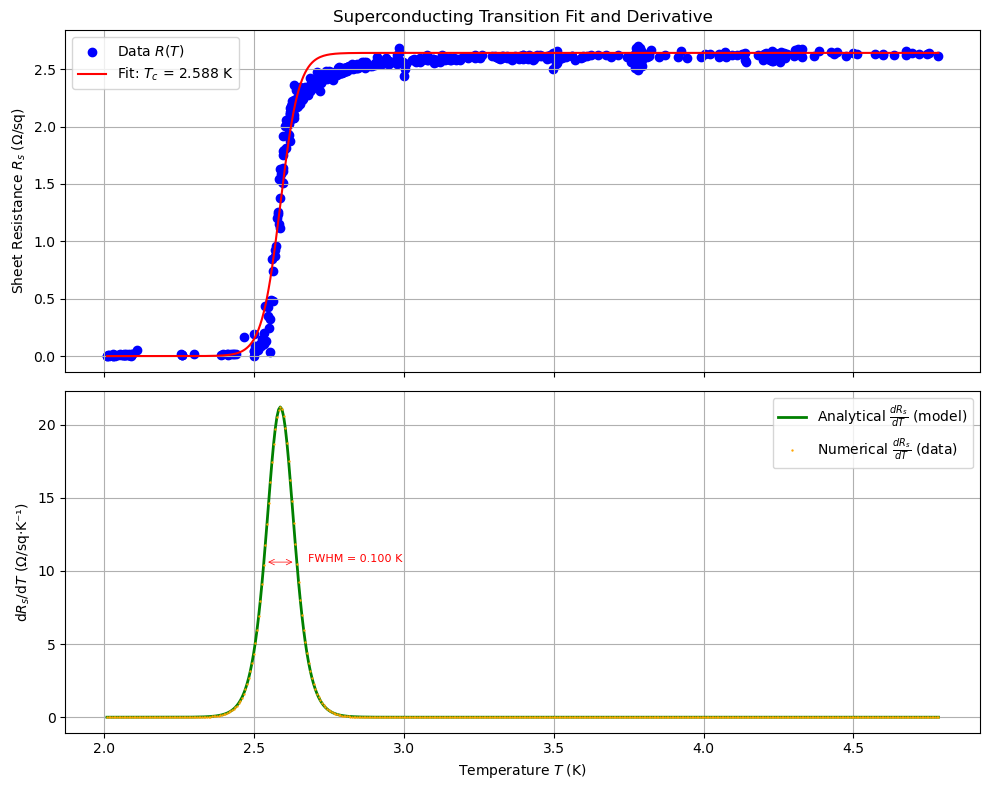

In [95]:


# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# R(T) and fit 
ax[0].scatter(Tf_sorted, Rs_sorted, label="Data $R(T)$", color='blue')
ax[0].plot(Tf_fit, Rs_fit, label=f"Fit: $T_c$ = {T_c_fit:.3f} K", color='red')
ax[0].set_ylabel("Sheet Resistance $R_s$ (Ω/sq)")
ax[0].set_title("Superconducting Transition Fit and Derivative")
ax[0].legend()
ax[0].grid(True)

# dR/dT and model derivative
label_text = f"FWHM = {FWHM:.3f} K"

# Draw the double arrow using annotate
ax[1].annotate(
    '', 
    xy=(T_c_fit - FWHM/2 + FWHM, np.max(dRs_fit)/2), 
    xytext=(T_c_fit - FWHM/2, np.max(dRs_fit)/2), 
    arrowprops=dict(arrowstyle='<->', color='red', linewidth=.5)
)

# Place the label in the middle of the arrow
x_mid = T_c_fit 
ax[1].text(x_mid+FWHM/2+.2, np.max(dRs_fit)/2-.1 , label_text, ha='center', va='bottom', fontsize=8, color='red')


ax[1].plot(Tf_valid, dRs_fit, label=r"Analytical $\frac{dR_s}{dT}$ (model)", color='green', linewidth=2)
ax[1].plot(Tf_fit, dRs_numeric, 'o', label=r"Numerical $\frac{dR_s}{dT}$ (data)", color='orange', markersize=.7)
#ax[1].plot([T_c_fit - FWHM/2, T_c_fit + FWHM/2], [np.max(dRs_fit)/2, np.max(dRs_fit)/2], color='black', linewidth=2)
ax[1].set_xlabel("Temperature $T$ (K)")
ax[1].set_ylabel("d$R_s$/d$T$ (Ω/sq·K⁻¹)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

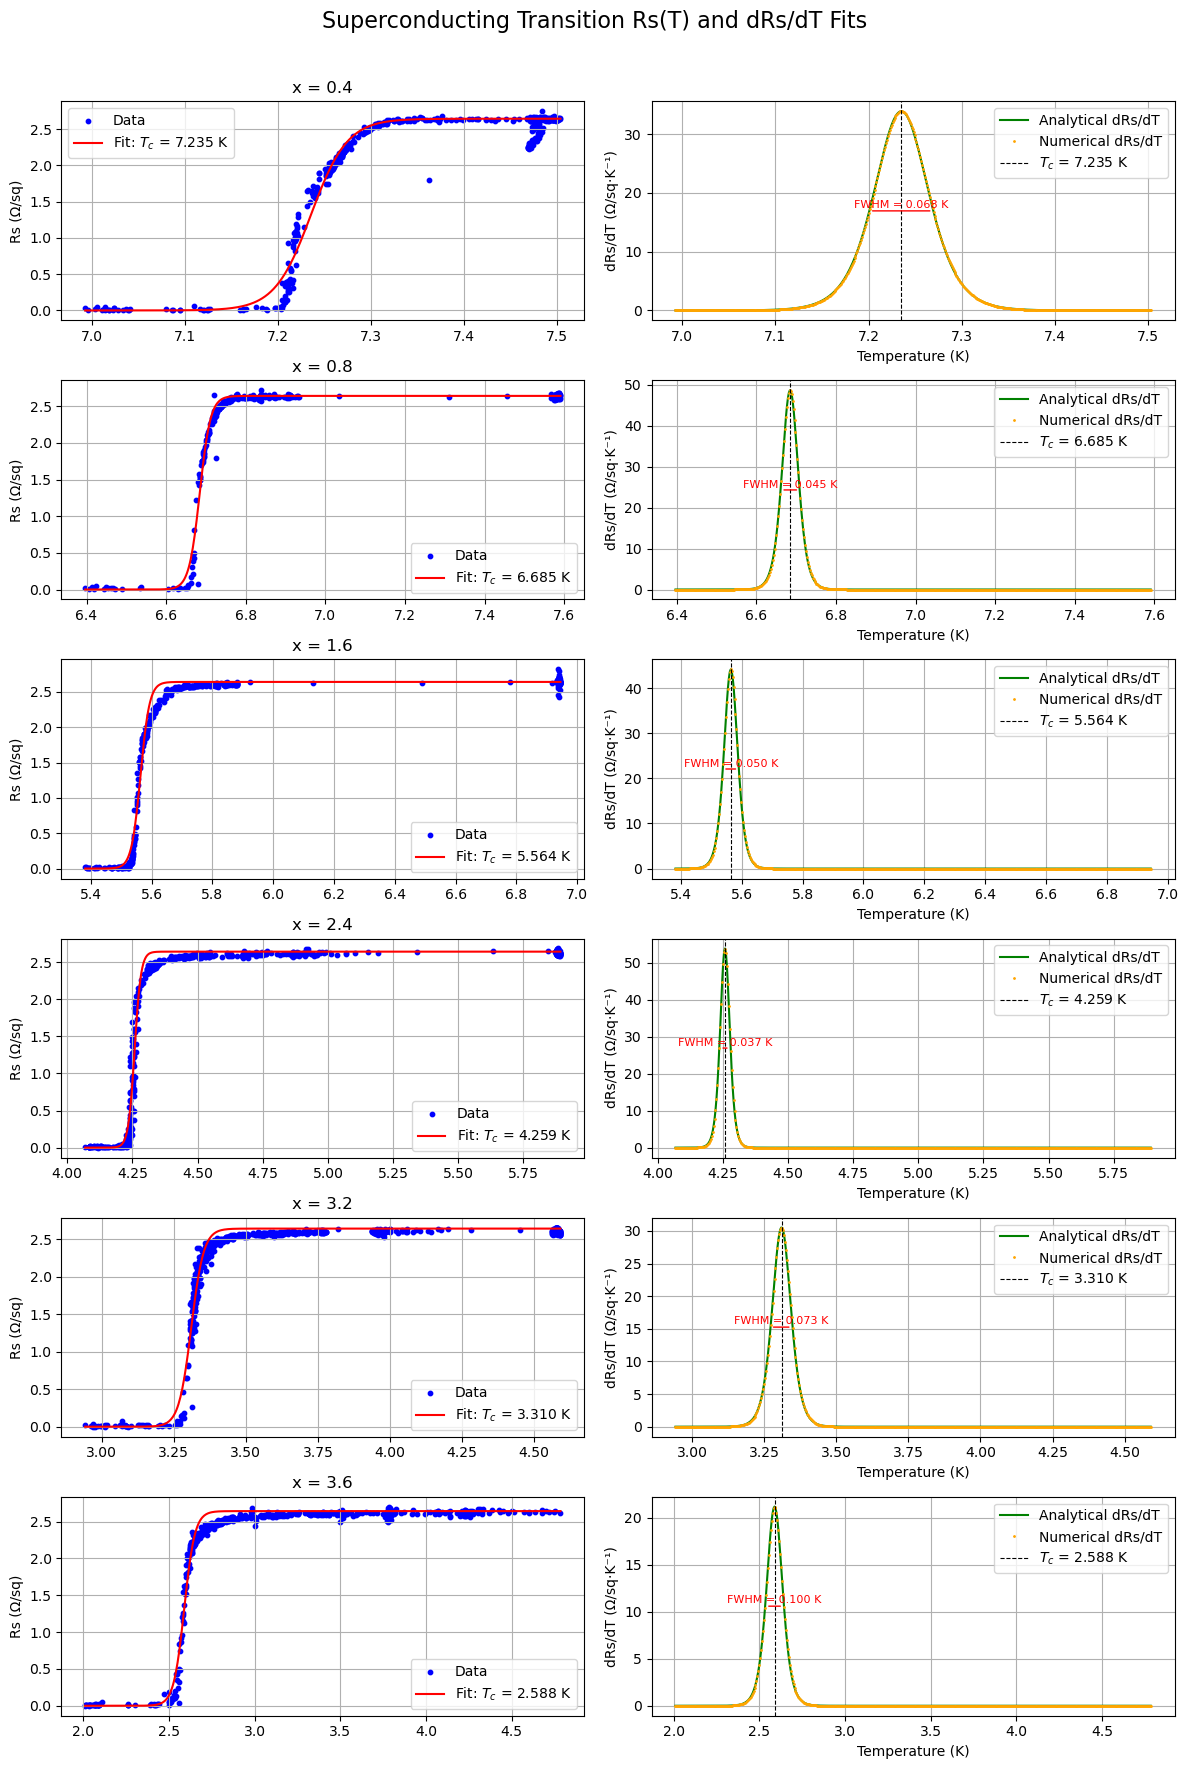

In [98]:
# --- X values from your original dataset names ---
x_vals = [0.4, 0.8, 1.6, 2.4, 3.2, 3.6]

# --- Plotting ---
fig, axs = plt.subplots(len(x_vals), 2, figsize=(12, 3 * len(x_vals)), sharex=False)
fig.suptitle("Superconducting Transition Rs(T) and dRs/dT Fits", fontsize=16)

for i, x in enumerate(x_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    # Sort
    sorted_idx = np.argsort(Tf)
    Tf_sorted = Tf[sorted_idx]
    Rs_sorted = Rs[sorted_idx]

    # Initial guess for Tc: where -dR/dT peaks
    guess_Tc = Tf_sorted[np.argmax(np.gradient(-Rs_sorted))]
    try:
        popt, _ = curve_fit(FD_model, Tf_sorted, Rs_sorted, p0=[guess_Tc, 0.1])
        T_c_fit, delta_T_fit = popt
    except RuntimeError:
        print(f"Fit did not converge for x={x}")
        continue

    # Evaluate Rs(T) model
    Tf_fit = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 500)
    Rs_fit = FD_model(Tf_fit, *popt)

    # Numerical derivative
    dRs_numeric = np.gradient(Rs_fit, Tf_fit)

    # Remove NaNs/infs
    valid_mask = np.isfinite(dRs_numeric) & np.isfinite(Tf_fit)
    Tf_valid = Tf_fit[valid_mask]
    dRs_numeric_valid = dRs_numeric[valid_mask]

    # Fit dR/dT model (optional — or just use analytical version)
    try:
        popt_dR, _ = curve_fit(dR_dT_FD, Tf_valid, dRs_numeric_valid, p0=popt)
        dRs_fit = dR_dT_FD(Tf_valid, *popt_dR)
    except RuntimeError:
        dRs_fit = dR_dT_FD(Tf_valid, *popt)

    # --- FWHM Calculation ---
    half_max = np.max(dRs_fit) / 2
    T_fwhm = Tf_valid[dRs_fit > half_max]
    FWHM = T_fwhm.max() - T_fwhm.min() if len(T_fwhm) > 1 else np.nan

    # --- Plot Rs(T) ---
    ax_r = axs[i, 0]
    ax_r.scatter(Tf_sorted, Rs_sorted, color='blue', s=10, label="Data")
    ax_r.plot(Tf_fit, Rs_fit, color='red', label=f"Fit: $T_c$ = {T_c_fit:.3f} K")
    ax_r.set_ylabel("Rs (Ω/sq)")
    ax_r.set_title(f"x = {x}")
    ax_r.legend()
    ax_r.grid(True)

    # --- Plot dRs/dT ---
    ax_d = axs[i, 1]
    ax_d.plot(Tf_valid, dRs_fit, label="Analytical dRs/dT", color='green')
    ax_d.plot(Tf_valid, dRs_numeric_valid, '.', label="Numerical dRs/dT", color='orange', markersize=2)

    # Draw FWHM arrow
    ax_d.annotate(
        '',
        xy=(T_fwhm.min(), half_max),
        xytext=(T_fwhm.max(), half_max),
        arrowprops=dict(arrowstyle='-', color='red', linewidth=1)
    )
    ax_d.text((T_fwhm.min() + T_fwhm.max()) / 2, half_max + 0.1, f"FWHM = {FWHM:.3f} K", 
              ha='center', va='bottom', fontsize=8, color='red')

    ax_d.axvline(T_c_fit, color='black', linestyle='--', linewidth=0.8, label=f"$T_c$ = {T_c_fit:.3f} K")
    ax_d.set_xlabel("Temperature (K)")
    ax_d.set_ylabel("dRs/dT (Ω/sq·K⁻¹)")
    ax_d.grid(True)
    ax_d.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()